In [2]:
import pandas as pd
import gies
from gies import utils
import sempler
import sempler.generators
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import time


def sample_data(scm, interventions,n=[10000],random_seed=0):
    return [scm.sample(n=n[interventions.index(intervention)%len(n)]  , do_interventions={target: (0,1) for target in intervention}, random_state=random_seed) for intervention in interventions]

Did not load sempler.semi module and sempler.DRFNet class - optional dependencies are missing. See https://github.com/juangamella/sempler#installation for more details. All other functionality is available.
No module named 'rpy2'


# Counterexample Consistency

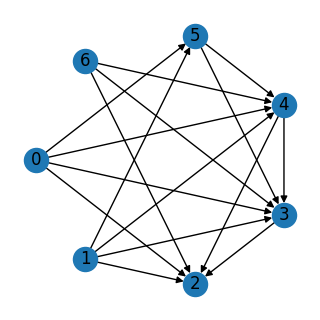

[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]] -47215758.505689844


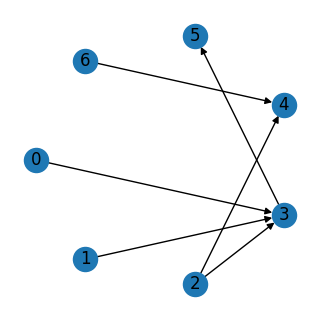

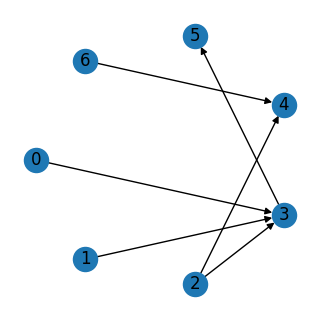

In [6]:
DAG7 = np.array([
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
])

LM7 = np.array([
    [0, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
])

#plot LM7
graph_DAG7 = nx.from_numpy_array(DAG7, create_using=nx.DiGraph)
layout = nx.shell_layout(graph_DAG7)
plt.figure(figsize=(3, 3))
nx.draw(nx.from_numpy_array(LM7,create_using=nx.DiGraph),layout, with_labels=True, arrows=True)
plt.show()

W_DAG7 = DAG7 * np.random.uniform(1, 2, DAG7.shape)
scm_DAG7 = sempler.LGANM(W_DAG7, (1, 2), (1, 2))
data_DAG7 = [scm_DAG7.sample(n=10000000), scm_DAG7.sample(n=10000, do_interventions={4: (0, 1)}), scm_DAG7.sample(n=10000, do_interventions={5: (0, 1)})]
interventions_DAG7 = [[],[4],[5]]
estimate_DAG7, score_DAG7 = gies.fit_bic(data_DAG7, interventions_DAG7,A0=LM7,debug=False)
print(estimate_DAG7, score_DAG7)
#plot origina next to estimated graph
plt.figure(figsize=(3, 3))
nx.draw(graph_DAG7, layout, with_labels=True, arrows=True)
plt.show()
plt.figure(figsize=(3, 3))
estimate_graph_DAG7 = nx.from_numpy_array(estimate_DAG7, create_using=nx.DiGraph)
nx.draw(estimate_graph_DAG7, layout, with_labels=True, arrows=True)



In [ ]:
resulting_graphs = pd.DataFrame(columns=["C","correct_estimate", "local_maximum", "phase", "score_change", "changed_edges", "graph"])
for C in [10,100, 1000, 10000, 100000]:
    for i in range (1000):
        np.random.seed(i)
        W_DAG7 = DAG7 * np.random.uniform(1, 2, DAG7.shape)
        scm_DAG7 = sempler.LGANM(W_DAG7, (1, 2), (1, 2), random_state=i)
        data_DAG7 = [scm_DAG7.sample(n=1000000), scm_DAG7.sample(n=1000000//C, do_interventions={4: (0, 1)}), scm_DAG7.sample(n=1000000//C, do_interventions={5: (0, 1)})]
        estimate_DAG7, score_DAG7 = gies.fit_bic(data_DAG7, interventions_DAG7,A0=utils.replace_unprotected(LM7,interventions_DAG7),debug=False)
        phase, old_A, new_A, score_change = gies.fit_bic_one_step(data_DAG7, interventions_DAG7, A0=utils.replace_unprotected(LM7,interventions_DAG7),debug=False)
        correct_estimate = np.array_equal(estimate_DAG7, DAG7)
        local_maximum = np.array_equal(estimate_DAG7, LM7)
        changed_edges = np.argwhere(new_A-old_A)
        resulting_graphs = pd.concat([resulting_graphs, pd.DataFrame([[C,correct_estimate, local_maximum, phase, score_change, changed_edges,estimate_DAG7]], columns=["C","correct_estimate", "local_maximum", "phase", "score_change", "changed_edges","graph"])])


In [56]:
resulting_graphs[["C","correct_estimate", "local_maximum", "phase"]].value_counts().sort_values().sort_index()
    

C       correct_estimate  local_maximum  phase    
10      False             False          forward        4
        True              False          forward      919
                                         turning       77
100     False             False          forward        1
                                         turning        1
        True              False          turning      998
1000    False             False          forward        2
                                         turning        1
        True              False          forward        1
                                         turning      996
10000   False             False          forward        4
                                         turning        1
                          True           no change     23
        True              False          turning      972
100000  False             False          forward        4
                                         turning       41
                     

In [50]:
resulting_graphs.groupby("phase").mean()

,C,correct_estimate,local_maximum,score_change,changed_edges,graph
phase,,,,,,
forward,483.775401,0.983957,0.0,30.483972,"[[4.980748663101604, 2.0192513368983955]]","[[0.0, 0.0053475935828877, 0.00320855614973262..."
no change,92959.183673,0.0,1.0,0.000000,[],"[[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [0.0, 0...."
turning,22096.968974,0.988332,0.0,756.750136,"[[3.0, 4.0], [4.0, 3.0]]","[[0.0, 0.0, 0.0098117210289048, 1.0, 0.0084858..."


In [51]:
resulting_graphs.to_csv("experiment_consistency.csv")

# Hidden Confounders

In [17]:
DAG_HC = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [1, 1, 0],
])
families =[
    [[]],
    [[],[0]],
    [[],[1]],
    [[0],[1]],
    [[],[0],[1]]
]
for interventions_DAG_HC in families:
    resulting_graphs ={}
    for i in range(10000):
        np.random.seed(i)
        W_DAG_HC = DAG_HC * np.random.uniform(0, 1, DAG_HC.shape)
        scm_DAG_HC = sempler.LGANM(W_DAG_HC, (0, 1), (0, 1),random_state=i)
        data_DAG_HC = sample_data(scm_DAG_HC, interventions_DAG_HC,[10000,10000,10000],random_seed=i)
        data_DAG_HC_hidden = [table[:,:2] for table in data_DAG_HC]
        estimate_DAG_HC, score_DAG_HC = gies.fit_bic(data_DAG_HC_hidden, interventions_DAG_HC,debug=False)
        graph_tuple = tuple(map(tuple, estimate_DAG_HC.tolist()))
        if graph_tuple in resulting_graphs:
            resulting_graphs[graph_tuple] += 1
        else:
            resulting_graphs[graph_tuple] = 1
    print(interventions_DAG_HC,":")
    print(resulting_graphs)


[[]] :
{((0.0, 1.0), (1.0, 0.0)): 8048, ((0.0, 0.0), (0.0, 0.0)): 1952}
[[], [0]] :
{((0.0, 0.0), (1.0, 0.0)): 7972, ((0.0, 1.0), (0.0, 0.0)): 48, ((0.0, 0.0), (0.0, 0.0)): 1980}
[[], [1]] :
{((0.0, 1.0), (0.0, 0.0)): 7973, ((0.0, 0.0), (0.0, 0.0)): 1988, ((0.0, 0.0), (1.0, 0.0)): 39}
[[0], [1]] :
{((0.0, 0.0), (0.0, 0.0)): 9966, ((0.0, 0.0), (1.0, 0.0)): 14, ((0.0, 1.0), (0.0, 0.0)): 20}
[[], [0], [1]] :
{((0.0, 0.0), (1.0, 0.0)): 3735, ((0.0, 1.0), (0.0, 0.0)): 3775, ((0.0, 0.0), (0.0, 0.0)): 2490}


In [19]:
for k in [0,0.25,0.5,1,2,5,10]:
    resulting_graphs ={}
    for i in range(10000):
        np.random.seed(i)
        W_DAG_HC = DAG_HC * np.random.uniform(0, 1, DAG_HC.shape)
        scm_DAG_HC = sempler.LGANM(W_DAG_HC, (0, 1), (0, 1),random_state=i)
        data_DAG_HC = sample_data(scm_DAG_HC, [[],[0],[1]],[int(10000*k),10000,10000],random_seed=i)
        data_DAG_HC_hidden = [table[:,:2] for table in data_DAG_HC]
        estimate_DAG_HC, score_DAG_HC = gies.fit_bic(data_DAG_HC_hidden, [[],[0],[1]],debug=False)
        graph_tuple = tuple(map(tuple, estimate_DAG_HC.tolist()))
        if graph_tuple in resulting_graphs:
            resulting_graphs[graph_tuple] += 1
        else:
            resulting_graphs[graph_tuple] = 1
    print(k,":")
    print(resulting_graphs)

0 :
{((0.0, 0.0), (0.0, 0.0)): 9966, ((0.0, 0.0), (1.0, 0.0)): 14, ((0.0, 1.0), (0.0, 0.0)): 20}
0.25 :
{((0.0, 0.0), (0.0, 0.0)): 4931, ((0.0, 0.0), (1.0, 0.0)): 2520, ((0.0, 1.0), (0.0, 0.0)): 2549}
0.5 :
{((0.0, 0.0), (1.0, 0.0)): 3230, ((0.0, 0.0), (0.0, 0.0)): 3502, ((0.0, 1.0), (0.0, 0.0)): 3268}
1 :
{((0.0, 0.0), (1.0, 0.0)): 3735, ((0.0, 1.0), (0.0, 0.0)): 3775, ((0.0, 0.0), (0.0, 0.0)): 2490}
2 :
{((0.0, 0.0), (1.0, 0.0)): 4059, ((0.0, 1.0), (0.0, 0.0)): 4122, ((0.0, 0.0), (0.0, 0.0)): 1819}
5 :
{((0.0, 0.0), (1.0, 0.0)): 4336, ((0.0, 0.0), (0.0, 0.0)): 1245, ((0.0, 1.0), (0.0, 0.0)): 4419}
10 :
{((0.0, 0.0), (1.0, 0.0)): 4480, ((0.0, 1.0), (0.0, 0.0)): 4542, ((0.0, 0.0), (0.0, 0.0)): 978}


# Hidden Confounder and Edge

In [ ]:
DAG_HCE = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [1, 1, 0],
])
families =[
    [[]],
    [[],[0]],
    [[],[1]],
    [[0],[1]],
    [[],[0],[1]]
]
for interventions_DAG_HCE in families:
    resulting_graphs ={}
    for i in range(10000):
        np.random.seed(i)
        W_DAG_HCE = DAG_HCE * np.random.uniform(0, 1, DAG_HCE.shape)
        scm_DAG_HCE = sempler.LGANM(W_DAG_HCE, (0, 1), (0, 1),random_state=i)
        data_DAG_HCE = sample_data(scm_DAG_HCE, interventions_DAG_HCE,[10000,10000,10000],random_seed=i)
        data_DAG_HCE_hidden = [table[:,:2] for table in data_DAG_HCE]
        estimate_DAG_HCE, score_DAG_HCE = gies.fit_bic(data_DAG_HCE_hidden, interventions_DAG_HCE,debug=False)
        graph_tuple = tuple(map(tuple, estimate_DAG_HCE.tolist()))
        if graph_tuple in resulting_graphs:
            resulting_graphs[graph_tuple] += 1
        else:
            resulting_graphs[graph_tuple] = 1

    print(interventions_DAG_HCE,":")
    print(resulting_graphs)

[[]] :
{((0.0, 1.0), (1.0, 0.0)): 9955, ((0.0, 0.0), (0.0, 0.0)): 45}
[[], [0]] :
{((0.0, 1.0), (0.0, 0.0)): 8656, ((0.0, 0.0), (1.0, 0.0)): 1314, ((0.0, 0.0), (0.0, 0.0)): 30}
[[], [1]] :
{((0.0, 1.0), (0.0, 0.0)): 9953, ((0.0, 0.0), (0.0, 0.0)): 46, ((0.0, 0.0), (1.0, 0.0)): 1}
[[0], [1]] :
{((0.0, 1.0), (0.0, 0.0)): 9755, ((0.0, 0.0), (0.0, 0.0)): 244, ((0.0, 0.0), (1.0, 0.0)): 1}
[[], [0], [1]] :
{((0.0, 1.0), (0.0, 0.0)): 9784, ((0.0, 0.0), (1.0, 0.0)): 174, ((0.0, 0.0), (0.0, 0.0)): 42}


# Hidden Mediator

In [62]:
DAG_HM = np.array([
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
])
DAG_V3 = np.array([
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 0],
])
families = [
    [[]],
    [[],[0]],
    [[],[2]],
    [[],[0,1]],
    [[],[0,2]],
    [[0],[1,2]],
    [[2],[0,1]],
    [[0],[1],[2]]
]
hidden_mediator_results = pd.DataFrame(columns=["intervention","correct_estimates_mediator", "correct_estimates_v3"])
for interventions_DAG_HM in families:
    correct_med = 0
    correct_v3 = 0
    for i in range(10000):
        np.random.seed(i)
        W_DAG_HM = DAG_HM * np.random.uniform(0, 1, DAG_HM.shape)
        W_DAG_V3 = DAG_V3 * np.random.uniform(0, 1, DAG_V3.shape)
        scm_DAG_HM = sempler.LGANM(W_DAG_HM, (0, 1), (0, 1),random_state=i)
        scm_DAG_V3 = sempler.LGANM(W_DAG_V3, (0, 1), (0, 1),random_state=i)
        data_DAG_HM = sample_data(scm_DAG_HM, interventions_DAG_HM,[10000,10000,10000],random_seed=i)
        data_DAG_V3 = sample_data(scm_DAG_V3, interventions_DAG_HM,[10000,10000,10000],random_seed=i)
        data_DAG_HM_hidden = [table[:,:3] for table in data_DAG_HM]
        estimate_DAG_HM, score_DAG_HM = gies.fit_bic(data_DAG_HM_hidden, interventions_DAG_HM,debug=False)
        correct_estimate_mediator = np.array_equal(estimate_DAG_HM, DAG_V3)
        estimate_DAG7, score_DAG7 = gies.fit_bic(data_DAG_V3, interventions_DAG_HM,debug=False)
        correct_estimate_v3 = np.array_equal(estimate_DAG7, DAG_V3)
        correct_med += correct_estimate_mediator
        correct_v3 += correct_estimate_v3
    hidden_mediator_results = pd.concat([hidden_mediator_results, pd.DataFrame([[interventions_DAG_HM,correct_med, correct_v3]], columns=["intervention","correct_estimates_mediator", "correct_estimates_v3"])])


print(hidden_mediator_results)

      intervention correct_estimates_mediator correct_estimates_v3
0             [[]]                       6490                 8916
0        [[], [0]]                       7258                 9233
0        [[], [2]]                       7270                 9117
0     [[], [0, 1]]                       8520                 9649
0     [[], [0, 2]]                       6428                 8873
0    [[0], [1, 2]]                       7095                 9216
0    [[2], [0, 1]]                       8316                 9571
0  [[0], [1], [2]]                       8478                 9601


# Runtime

In [13]:
def get_interventions(p=10): #p has to be at least 3
    conservative = False
    while not conservative:
        conservative = True
        family = sempler.generators.intervention_targets(p,5,(0,3),replace=True)
        for j in range(p):
            not_intervened = False
            for I in family:
                if j not in I:
                    not_intervened = True
                    break
            if not not_intervened:
                conservative = False
                break
    return family

In [ ]:
for n in [100,1000,10000,100000,1000000,10000000]:
    total_time = 0
    iterations = 100
    for i in range(iterations):
        DAG_n = sempler.generators.dag_avg_deg(10, 3,random_state=i)
        interventions_DAG_n = get_interventions()
        np.random.seed(i)
        W_DAG_n = DAG_n * np.random.uniform(0, 1, DAG_n.shape)
        scm_DAG_n = sempler.LGANM(W_DAG_n, (0, 1), (0, 1))
        data_DAG_n = sample_data(scm_DAG_n, interventions_DAG_n,[n],random_seed=i)
        start = time.time()
        estimate_DAG_n, score_DAG_n = gies.fit_bic(data_DAG_n, interventions_DAG_n,debug=False)
        end = time.time()
        total_time += end-start
    print("average time for n = ",n)
    print(total_time/iterations)

average time for n =  100
0.2160414218902588
average time for n =  1000
0.24557526111602784
average time for n =  10000
0.28929145336151124
average time for n =  100000
0.3207599401473999
average time for n =  1000000
0.7774454116821289
average time for n =  10000000
14.63406970500946


In [20]:
Original values:
n time
100 0.19226925134658812
1000 0.20765711069107057
10000 0.21052936792373658
100000 0.25554819822311403
1000000 0.7131900811195373
10000000 10.332595777511596

SyntaxError: invalid syntax (3984800704.py, line 1)

In [97]:
for p in range(3,15):
    n =1000
    iterations = 100
    total_time = 0
    for i in range(iterations):
        DAG_p = sempler.generators.dag_avg_deg(p, 3,random_state=i)
        interventions_DAG_p = get_interventions(p)
        W_DAG_p = DAG_p * np.random.uniform(0, 1, DAG_p.shape)
        scm_DAG_p = sempler.LGANM(W_DAG_p, (0, 1), (0, 1))
        data_DAG_p = sample_data(scm_DAG_p, interventions_DAG_p,[n],random_seed=i)
        start = time.time()
        estimate_DAG_p, score_DAG_p = gies.fit_bic(data_DAG_p, interventions_DAG_p,debug=False)
        end = time.time()
        total_time += end-start
    print(p,total_time/iterations)


3 0.0037503886222839357
4 0.008512094020843505
5 0.016990675926208496
6 0.030462183952331544
7 0.05345720529556274
8 0.08994344234466553
9 0.16709240436553954
10 0.3072446870803833


KeyboardInterrupt: 